## UMAP clustering on re-trained with k-maens 300 epochs (without PCA)   
    - 102 epochs initial (kmeans)
    - 200 additional epochs (kmeans)
    - train data:
    
```
Haus8 sgRNA #1	190219_195942-V	B12	
Haus8 sgRNA #2	190219_195942-V	E1	
Haus8 sgRNA #3	190219_195942-V	F2	
Haus8 sgRNA #4	190219_195942-V	G2	
DyncH1 sgRNA #3	190219_195942-V	A1	
Incenp sgRNA #1	190219_195942-V	G4	
Incenp sgRNA #2	190219_195942-V	G6	
Incenp sgRNA #3	190219_195942-V	H1	
Rad21 sgRNA #1	190219_195942-V	H3	
Rad21 sgRNA #2	190219_195942-V	H5	
Rad21 sgRNA #3	190219_195942-V	H7
```
    - test: 

```
Incenp sgRNA #1	190219_195942-V	G5	
Incenp sgRNA #2	190219_195942-V	G8	
No sgRNA Pt11_r01_c12
```
    - clustering with K-means, spectral, ward, agglomerative, OPTICS, birch

Additional cluster comparisons  
Also using 20 UMAP dimensions for clustering, but visualizing in 2 UMAP

In [1]:
import time
import matplotlib.pyplot as plt
import os
import numpy as np
import anndata as ad
import torch
from sklearn.decomposition import PCA
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from PIL import Image
from torch.autograd import Variable
from util import load_model
from util import AverageMeter, Logger, UnifLabelSampler
import shutil
import seaborn as sn
import scanpy.api as sc
import pandas as pd

/home/aogorodnikov/anaconda3/envs/imgSudoku/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
model=load_model('/home/aogorodnikov/model_alex_kmeans300/checkpoint.pth.tar')

=> loading checkpoint '/home/aogorodnikov/model_alex_kmeans300/checkpoint.pth.tar'
Loaded


In [4]:
model.cuda()
model.eval()


AlexNet(
  (features): Sequential(
    (0): Conv2d(2, 96, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace)
    (11): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace)
    (14): Conv2d(384, 256, kernel_si

In [5]:
model.top_layer = None
model.classifier = nn.Sequential(*list(model.classifier.children())[:-1])

In [6]:
def compute_features(dataloader, model, N):
    
    batch_time = AverageMeter()
    end = time.time()
    model.eval()
    # discard the label information in the dataloader
    for i, (input_tensor, _) in enumerate(dataloader):
        with torch.no_grad():
            input_var = torch.autograd.Variable(input_tensor.cuda())
            aux = model(input_var).data.cpu().numpy()
            if i == 0:
                features = np.zeros((N, aux.shape[1])).astype('float32')

            if i < len(dataloader) - 1:
                features[i * 256: (i + 1) * 256] = aux.astype('float32')
            else:
                # special treatment for final batch
                features[i * 256:] = aux.astype('float32')

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()
        

    return features

In [7]:
data_dir = '/home/aogorodnikov/eval'

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
tra = [transforms.Resize(256),
       transforms.CenterCrop(224),
       transforms.ToTensor(),
       normalize]
dataset = datasets.ImageFolder(data_dir, transform=transforms.Compose(tra))
dataloader = torch.utils.data.DataLoader(dataset,
                                         batch_size=256,
                                         num_workers=8,
                                         pin_memory=True)



In [8]:
%%time
features = compute_features(dataloader, model, len(dataset))

CPU times: user 2min 8s, sys: 2min 33s, total: 4min 41s
Wall time: 4min 12s


In [9]:
features.shape

(203428, 4096)

In [10]:
np.random.seed(33)

In [11]:
# get the file names
dataset.samples[0][0]
samples = [x[0] for x in dataset.samples]


In [12]:
# construct AnnData obj
adata = ad.AnnData(X=features, obs = samples)
adata.obs["well"] = adata.obs.iloc[:,0].str.extract(r'(Pt\d+_r\d+c\d+)')
adata.obs["image_ID"] = [os.path.splitext(os.path.basename(x))[0] for x in adata.obs.iloc[:,0]]



In [13]:
# downsample data
adata = adata[np.random.choice(range(0,adata.shape[0]), size=round(adata.shape[0]*0.2), replace=False),:]

In [14]:
adata

View of AnnData object with n_obs × n_vars = 40686 × 4096 
    obs: 0, 'well', 'image_ID'

### UMAP embedding without PCA

In [15]:
# Dimension reduction and clustering libraries
import umap

In [16]:
# euclidean

reducer = umap.UMAP(random_state=42, min_dist=0.0, n_components=2)
embedding_euc = reducer.fit_transform(adata.X)

In [24]:
# euclidean in 20 UMAP

reducer = umap.UMAP(random_state=42, min_dist=0.0, n_components=20)
embedding_euc_10d = reducer.fit_transform(adata.X)

## Clustering approaches

## K-means

In [18]:
from sklearn.cluster import KMeans

In [25]:
labels = KMeans(init='k-means++', n_clusters=80, n_init=30).fit(embedding_euc_10d).labels_

In [26]:
labels


array([45, 61, 59, ..., 55, 75,  3], dtype=int32)

In [27]:
'''
function to loop over different clustering parametersand find clusters with highest difference b/w positive and negative controls
data - array (UMAP coordinates)
param - parameter to loop for
'''

def dif_clust(data, param):
    labels = KMeans(init='k-means++', n_clusters=param, n_init=10).fit(data).labels_
    df_emb = pd.DataFrame(data)
    df_emb['well'] = adata.obs["well"].tolist()
    df_emb['image_ID'] = [os.path.splitext(os.path.basename(x))[0] for x in adata.obs.iloc[:,0]]
    df_emb['clust'] = [",".join(['', str(x)]) for x in labels]

    clust_ls = []
    for well in df_emb.well.unique():
        sum_well = len(df_emb.clust[df_emb.well == well])
        for i in df_emb.clust.unique():
            res = [well, i, len(df_emb.clust[(df_emb.clust == i) & (df_emb.well == well)]) / sum_well * 1e4]
            clust_ls.append(res)
    clust_df = pd.DataFrame(clust_ls, columns=['well', 'class', 'n_samp'])
    max_ratios = []
    for clust in clust_df['class'].unique():
        ns_ctrl = clust_df.loc[(clust_df['class'] == clust) & (clust_df['well'] == "Pt11_r02c12"), "n_samp"]
        ns_pos1 = clust_df.loc[(clust_df['class'] == clust) & (clust_df['well'] == "Pt04_r07c05"), "n_samp"]
        ns_pos2 = clust_df.loc[(clust_df['class'] == clust) & (clust_df['well'] == "Pt04_r07c08"), "n_samp"]
        max_ratios.append(max([ns_pos1.iloc[0]/ns_ctrl.iloc[0], ns_pos2.iloc[0]/ns_ctrl.iloc[0]]))
        
    return(max(max_ratios))

In [28]:
# loop over parameters of clustering
params = [10,20,50,80,100,200,300]
max_difference = [dif_clust(embedding_euc_10d, param) for param in params]
max_difference_df = pd.DataFrame([params, max_difference])

In [29]:
max_difference_df

,0,1,2,3,4,5,6
0,10.000000,20.000000,50.000000,80.000000,100.000000,200.000000,300.000000
1,1.962248,2.112895,2.982581,3.917744,3.736399,5.423263,7.000989


In [50]:
df_emb = pd.DataFrame(embedding_euc)
df_emb['well'] = adata.obs["well"].tolist()
df_emb['image_ID'] = [os.path.splitext(os.path.basename(x))[0] for x in adata.obs.iloc[:,0]]
df_emb['clust'] = [",".join(['', str(x)]) for x in labels]

df_emb.sort_values('image_ID').head()




,0,1,well,image_ID,clust
40201,0.927354,-0.377376,Pt04_r07c05,Pt04_r07c05_f01_0001,",51"
40331,3.608083,-2.029314,Pt04_r07c05,Pt04_r07c05_f01_0002,",18"
2345,-6.275246,-2.970483,Pt04_r07c05,Pt04_r07c05_f01_0003,",47"
8324,-0.713024,0.284355,Pt04_r07c05,Pt04_r07c05_f01_0005,",65"
11492,-0.385192,0.002824,Pt04_r07c05,Pt04_r07c05_f01_0008,",2"


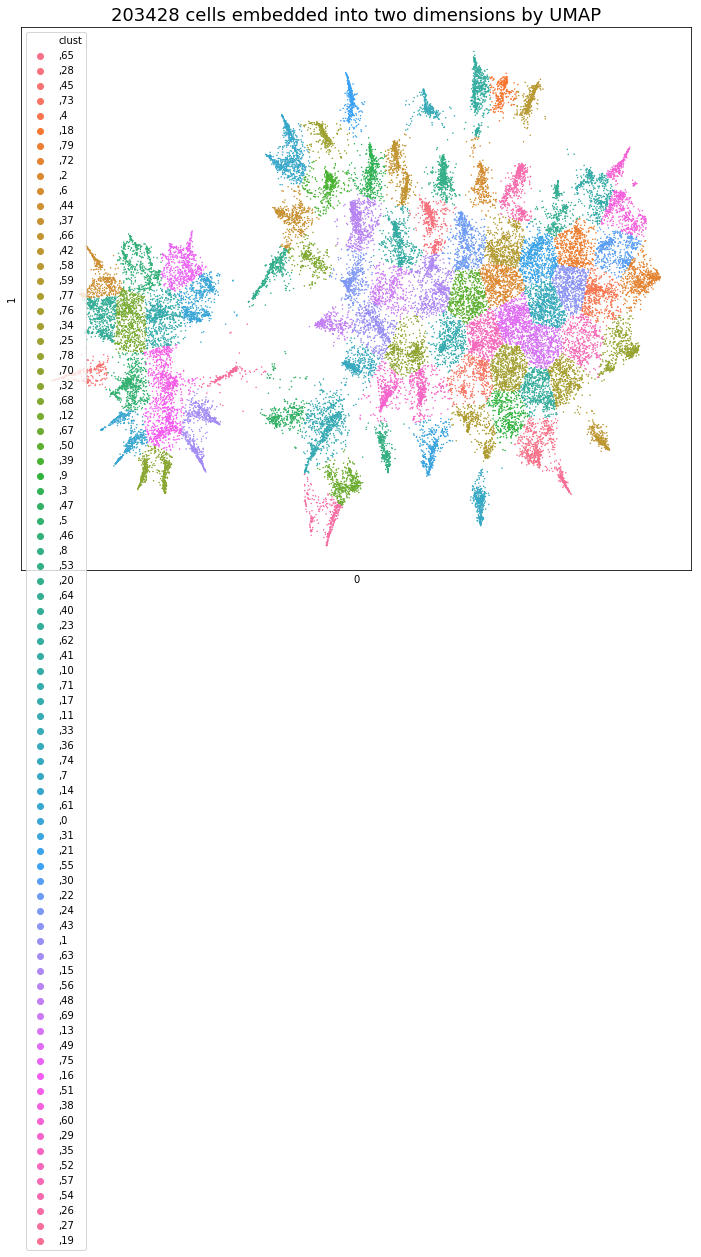

In [36]:
fig, ax = plt.subplots(figsize=(12, 10))
sn.scatterplot(df_emb.iloc[:, 0], df_emb.iloc[:, 1], hue=df_emb.clust, s=0.5, edgecolor=None)
plt.title("203428 cells embedded into two dimensions by UMAP", fontsize=18)
plt.setp(ax, xticks=[], yticks=[])


plt.show()

In [44]:
df_emb_clust = pd.DataFrame(embedding_euc)
df_emb_clust['well'] = adata.obs["well"].tolist()
df_emb_clust['image_ID'] = [os.path.splitext(os.path.basename(x))[0] for x in adata.obs.iloc[:,0]]
df_emb_clust['clust'] = [",".join(['', str(x)]) if x == 1 else ",".join(['', str(0)]) for x in labels]


df_emb_clust.sort_values('image_ID').head()




,0,1,well,image_ID,clust
35802,5.888779,0.038013,Pt04_r07c05,Pt04_r07c05_f01_0003,",0"
37634,3.579357,-1.939571,Pt04_r07c05,Pt04_r07c05_f01_0006,",0"
27236,0.475920,0.546883,Pt04_r07c05,Pt04_r07c05_f01_0015,",0"
11787,3.261851,-1.895822,Pt04_r07c05,Pt04_r07c05_f01_0017,",0"
11558,0.734706,-1.899009,Pt04_r07c05,Pt04_r07c05_f01_0018,",0"


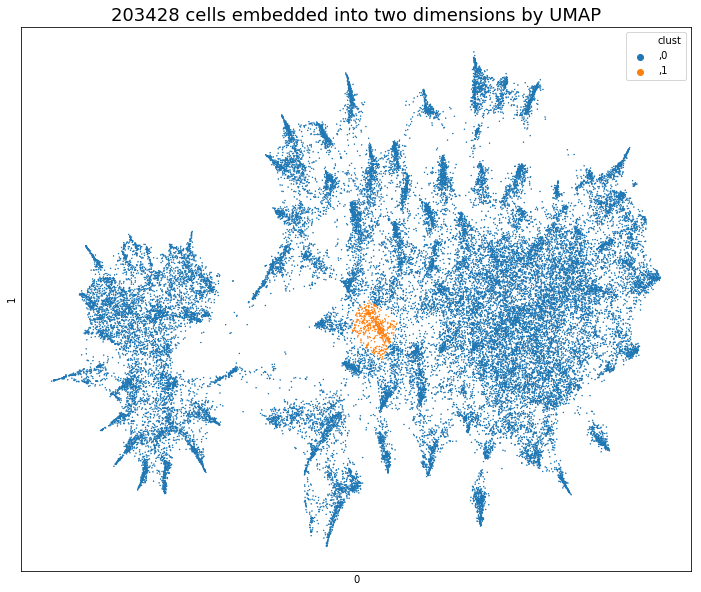

In [45]:
fig, ax = plt.subplots(figsize=(12, 10))
sn.scatterplot(df_emb.iloc[:, 0], df_emb.iloc[:, 1], hue=df_emb_clust.clust, s=0.5, edgecolor=None)
plt.title("203428 cells embedded into two dimensions by UMAP", fontsize=18)
plt.setp(ax, xticks=[], yticks=[])


plt.show()

### Compare cluster sizes between samples  


In [51]:
## kmeans
clust_ls = []
for well in df_emb.well.unique():
    sum_well = len(df_emb.clust[df_emb.well == well])
    for i in df_emb.clust.unique():
        res = [well, i, len(df_emb.clust[(df_emb.clust == i) & (df_emb.well == well)]) / sum_well * 1e4]
        clust_ls.append(res)

In [52]:
clust_df = pd.DataFrame(clust_ls, columns=['well', 'class', 'n_samp'])

In [53]:
clust_df.head()

,well,class,n_samp
0,Pt04_r07c05,",77",124.608087
1,Pt04_r07c05,",31",118.980625
2,Pt04_r07c05,",32",66.725621
3,Pt04_r07c05,",24",177.667015
4,Pt04_r07c05,",22",166.412091


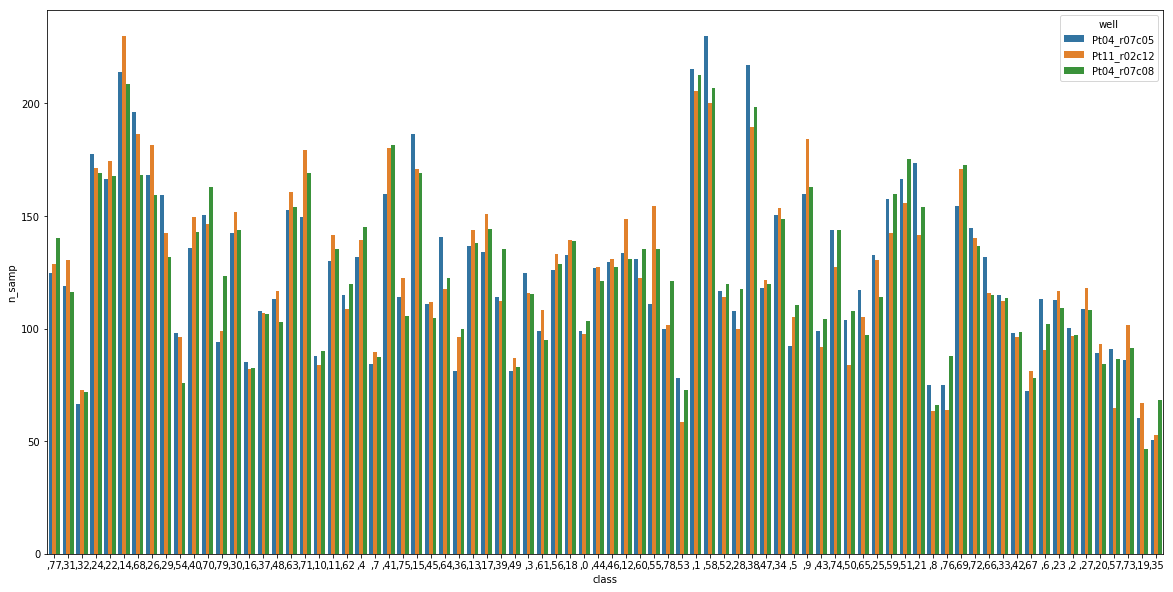

In [54]:
fig, ax = plt.subplots(figsize=(20, 10))
sn.barplot(x="class", y="n_samp", hue="well", data=clust_df)

### Clusters to export  


In [31]:
import re
import cv2

In [32]:
df_emb.head()

,0,1,well,image_ID,clust
0,3.113234,-3.057437,Pt04_r07c08,Pt04_r07c08_f76_0425,",73"
1,0.884884,1.453785,Pt04_r07c05,Pt04_r07c05_f86_0485,",51"
2,-6.958601,-1.473656,Pt04_r07c08,Pt04_r07c08_f30_0263,",42"
3,2.270180,-1.528339,Pt04_r07c05,Pt04_r07c05_f25_0429,",52"
4,-6.937983,-1.432529,Pt04_r07c05,Pt04_r07c05_f39_0480,",42"


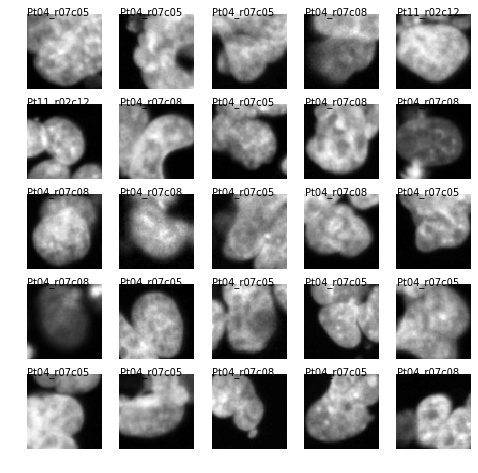

In [43]:
fig=plt.figure(figsize=(8, 8))
columns = 5
rows = 5
for k in range(1, columns * rows + 1):
    select_im = df_emb.loc[df_emb.clust  == ',1', "image_ID"].to_list()
    rand_select = [select_im[x] for x in np.random.choice(range(1, len(select_im)), 1)][0]
    img_import = cv2.imread("".join(['/home/aogorodnikov/eval/data/',rand_select, ".tif"]), -1)
    subplot = fig.add_subplot(rows, columns, k)
    plt.text(0, 0, s=re.search(r'(Pt\d+_r\d+c\d+)', rand_select)[0])
    plt.imshow(img_import, cmap='gray');
    plt.axis('off')

### conclusion k-means  
biggest difference pos control to negative controls (7.000989) is with 300 clusters. Too many clusters. Increasing of UMAP dimension to 10 or 20 didn't give any advantage (with K-menas)

# CONCLUSIONS  
Increasing of UMAP dimension to 10 or 20 didn't give any advantage with K-menas. Didn't test with the other algorithms